# DS 5110 Group Project
Team: Alexandra Cathcart (adc6fs), Benjamin Feciura (bmf3bw), Jeremey Donovan (jdd5dw), Jordan Hiatt (jdh2e)

Original data: https://www.kaggle.com/reddit/reddit-comments-may-2015


## Includes & Spark Setup

In [109]:
import pandas as pd
from matplotlib import pyplot as plt

import time

from pyspark import StorageLevel

from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import *
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder

from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import col, countDistinct, lower, size, split, udf, when
from pyspark.sql.types import ArrayType, FloatType, IntegerType,  StringType, StructType

In [2]:
#from pyspark import SparkContext
spark = SparkSession.builder.getOrCreate()
sc=spark.sparkContext

## Code Control

In [46]:
# EDA is a little slow so runEDA = 1 to run
runEDA=1

In [4]:
# train, test, holdout
# key code control b/c we have been experiencing memory issues with a 50/50 train/test split
trainPct=0.1
testPct=0.1
holdoutPct=0.8


In [5]:
# persisting trainDF should speed training but we have been experiencing memory issues
persistTrainDF=0

In [6]:
# Over-ride parallelism: We have been expreiencing memory issues. Set to anything other than 0 to override.
# Otherwise, set to the desired over-ride integer value
overrideParallelism=1

In [7]:
# loadCVmodel: If blank, then do not load and instead run CV
# otherwise, provide name of cv model to load
#loadCVmodel=""
loadCVmodel="lrModel20210730-005848"

loadCVmodelSens="lrModelSens20210730-093722"

In [110]:
# NOT IMPLEMENTED!!!
"""
# loadRFmodel: If blank, then do not load and instead run RF baseline model
# otherwise, provide name of RF model to load
#loadCVmodel=""
loadRFmodel="rfModel20210730-211517"
"""

## Data Import and Pre-Processing

### Data Import

In [8]:
# Import the reddit data
full_path = '/project/ds5559/r-slash-group8/sample.csv'

df = spark.read.csv(full_path,  inferSchema=True, header = True)

In [9]:
# Import the Bad Word data
schema = StructType().add("badWord",StringType(),True)
dfBW=spark.read.format("csv").schema(schema).load('bad_words.csv')
#  dfBW.show(5)  # not showing since words are quite vulgar

# Also create in list format
listBW=list(dfBW.select('badWord').toPandas()['badWord']) 
# listBW


In [10]:
# Create a regex with all the bad words
# if there is an issue, try \\\\b instead; just \b probably has issues
listBW=list(map(lambda line: "\\b" + line + "\\b",listBW))
delim='|'
strBW=delim.join(listBW)



### Filtering

In [11]:
# Drop unneeded cols from dataframe
df=df.drop('_c0','created_utc','subreddit_id','link_id','name','score_hidden','author_flair_css_class', 'gilded', \
        'author_flair_text','id','archived','retrieved_on', 'edited','controversiality','parent_id','score')

# convert integer cols (ups, downs, and gilded) to integers
# Note: we could have done this by defining a schema before the csv read
df=df.withColumn("ups",df.ups.cast(IntegerType()))
df=df.withColumn("downs",df.downs.cast(IntegerType()))
#df=df.withColumn("gilded",df.gilded.cast(IntegerType()))  # Removed gilded since not used in this analysis

# Confirm new schema
df.printSchema()
df.show(5)

root
 |-- ups: integer (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- removal_reason: string (nullable = true)
 |-- downs: integer (nullable = true)
 |-- author: string (nullable = true)
 |-- body: string (nullable = true)
 |-- distinguished: string (nullable = true)

+----+---------+--------------+-----+------------+--------------------+-------------+
| ups|subreddit|removal_reason|downs|      author|                body|distinguished|
+----+---------+--------------+-----+------------+--------------------+-------------+
|   4|soccer_jp|            NA|    0|       rx109|                くそ|         null|
|null|     null|          null| null|        null|                null|         null|
|   0|     null|          null| null|        null|                null|         null|
|   4|      nba|            NA|    0|   WyaOfWade|gg this one's ove...|           NA|
|   0| politics|            NA|    0|Wicked_Truth|Are you really im...|           NA|
+----+---------+------------

In [12]:
# Count the number of rows before removing NA
df.count()
# There are 15,317,725 rows

15317725

In [13]:
# Remove rows where up, down, or body is null. We  do this since inference of these values is not applicable
df=df.filter(df['ups'].isNotNull())
df=df.filter(df['downs'].isNotNull())
df=df.filter(df['body'].isNotNull())

df.show(5)

+---+---------+--------------+-----+--------------+--------------------+-------------+
|ups|subreddit|removal_reason|downs|        author|                body|distinguished|
+---+---------+--------------+-----+--------------+--------------------+-------------+
|  4|soccer_jp|            NA|    0|         rx109|                くそ|         null|
|  4|      nba|            NA|    0|     WyaOfWade|gg this one's ove...|           NA|
|  0| politics|            NA|    0|  Wicked_Truth|Are you really im...|           NA|
|  3|AskReddit|            NA|    0|      jesse9o3|No one has a Euro...|           NA|
|  3|AskReddit|            NA|    0|beltfedshooter|"That the kid ""....|           NA|
+---+---------+--------------+-----+--------------+--------------------+-------------+
only showing top 5 rows



In [14]:
# Remove rows where the author was '[deleted]' 
df=df.filter(df['author']!='[deleted]')

# Remove author "0"
df=df.filter(df['author']!='0')


# Remove rows where the author was 'AutoModerator'
# see https://www.reddit.com/wiki/automoderator
df=df.filter(df['author']!='AutoModerator')

In [15]:
# Count the number of rows AFTER removing NA
df.count()
# There now 9,226,090 rows

9226090

### Binning & Feature Engineering

In [16]:
# Lowercase all body text
df=df.withColumn('body',lower(col('body')))

In [17]:
# Even though we dropped the column, adding score back into dataframe by computing it
df=df.withColumn('score',df['ups']-df['downs'])
df=df.withColumn("score",df.score.cast(IntegerType()))
df.show(5)

+---+---------+--------------+-----+--------------+--------------------+-------------+-----+
|ups|subreddit|removal_reason|downs|        author|                body|distinguished|score|
+---+---------+--------------+-----+--------------+--------------------+-------------+-----+
|  4|soccer_jp|            NA|    0|         rx109|                くそ|         null|    4|
|  4|      nba|            NA|    0|     WyaOfWade|gg this one's ove...|           NA|    4|
|  0| politics|            NA|    0|  Wicked_Truth|are you really im...|           NA|    0|
|  3|AskReddit|            NA|    0|      jesse9o3|no one has a euro...|           NA|    3|
|  3|AskReddit|            NA|    0|beltfedshooter|"that the kid ""....|           NA|    3|
+---+---------+--------------+-----+--------------+--------------------+-------------+-----+
only showing top 5 rows



In [18]:
# Determine a scoreSentiment as either postive, neutral, or negative.
# This will be our response variable

# Drop scoreSentiment if it already exists
df=df.drop('scoreSentiment')

# Set up bucketizer
splits = [-float("inf"), -0.1,0.1, float("inf")]
bkt = Bucketizer(splits=splits, inputCol="score", outputCol="scoreSentiment")

# Transform to add scoreSentiment: 0=negative; 1=neutral; 2=positive.
df=bkt.transform(df)

# !!! Cannot shift to -1,0,1 since LR must start with 0 !!!
# To make things more clear, shift to -1=negative; 0=neutral; 1=positive
#df=df.withColumn("scoreSentiment", \
#                 when(df['scoreSentiment']==0,-1) \
#                 .when(df['scoreSentiment']==1,0) \
#                 .otherwise(1)
#                ) 

df.show(2)



+---+---------+--------------+-----+---------+--------------------+-------------+-----+--------------+
|ups|subreddit|removal_reason|downs|   author|                body|distinguished|score|scoreSentiment|
+---+---------+--------------+-----+---------+--------------------+-------------+-----+--------------+
|  4|soccer_jp|            NA|    0|    rx109|                くそ|         null|    4|           2.0|
|  4|      nba|            NA|    0|WyaOfWade|gg this one's ove...|           NA|    4|           2.0|
+---+---------+--------------+-----+---------+--------------------+-------------+-----+--------------+
only showing top 2 rows



In [19]:
# Flag comments containing bad words
df=df.withColumn('bwFlag',col('body').rlike(strBW))

In [20]:
# Append bodyWordCount
df=df.withColumn("bodyWordCount", size(split(df['body'], ' ')))
#df.show(5)

In [21]:
# Though not the cleanest thing to do from a data sci perspective, we
# are going to drop the neutral sentiment rows so we can do binomial
# rather than multinomial regression; neutral currently "1"
df=df.filter(df['scoreSentiment']!=1)
# Shift positive from 2 to 1
df=df.withColumn("scoreSentiment", \
                 when(df['scoreSentiment']==2,1) \
                 .when(df['scoreSentiment']==0,0) \
                 .otherwise(-1)
                ) 
# we should never have the otherwise case!!!

In [22]:
# Cross-validator explicity wants response to be called "label"
# so copying scoreSentiment to label in all DFs
df=df.withColumn("label", df["scoreSentiment"])

## Data Splitting & Sampling

In [23]:
seed=314
trainDF,testDF, holdoutDF=df.randomSplit([trainPct,testPct,holdoutPct],seed)

## EDA

In [75]:
if runEDA:
    # How many comments have bad words?
    # Confirm the flagging worked by looking at how many comments contain bad words vs good
    # NOTE: This has a rather long runtime!!!
    df.groupby('bwFlag').agg({"bwFlag":"count"}).show()
    #df.filter(df['bwFlag']==True).show(5,False)

+------+-------------+
|bwFlag|count(bwFlag)|
+------+-------------+
|  true|       392771|
| false|      8433257|
+------+-------------+



In [76]:
if runEDA:
    # How many authors are there?
    df.select(countDistinct('author')).show()
    # There are 1,216,598 authors

+----------------------+
|count(DISTINCT author)|
+----------------------+
|               1216598|
+----------------------+



In [77]:
if runEDA:
    # Show the top 10 authors with sum of ups and downs
    df.groupby('author').agg({"author":"count","ups":"sum","downs":"sum","score":"sum"}).sort(col('count(author)').desc()).show(10)

+-------------------+----------+----------+-------------+--------+
|             author|sum(score)|sum(downs)|count(author)|sum(ups)|
+-------------------+----------+----------+-------------+--------+
|      TheNitromeFan|     10445|         0|         3997|   10445|
|        TweetPoster|      7090|         0|         3452|    7090|
|        autowikibot|      6420|         0|         3188|    6420|
|         PoliticBot|      3159|         0|         3138|    3159|
|TweetsInCommentsBot|      9965|         0|         2999|    9965|
|     atomicimploder|      7363|         0|         2616|    7363|
|       Removedpixel|      5333|         0|         2264|    5333|
|          TrollaBot|      2640|         0|         2212|    2640|
|          havoc_bot|      2120|         0|         2101|    2120|
|     MTGCardFetcher|      3089|         0|         2053|    3089|
+-------------------+----------+----------+-------------+--------+
only showing top 10 rows



Odd that the preceding authors have no down but this is correct

In [78]:
if runEDA:
    # Show authors with the lowest scores
    df.groupby('author').agg({"score":"sum","ups":"sum","downs":"sum"}).sort(col('sum(score)').asc()).show(10)

+----------------+----------+----------+--------+
|          author|sum(score)|sum(downs)|sum(ups)|
+----------------+----------+----------+--------+
|    ItWillBeMine|     -6839|         0|   -6839|
|        blaghart|     -4233|         0|   -4233|
|       Shanondoa|     -3555|         0|   -3555|
|   bad_driverman|     -3053|         0|   -3053|
|      RSneedsEoC|     -2192|         0|   -2192|
|   b00gymonster1|     -2050|         0|   -2050|
|      frankenham|     -2024|         0|   -2024|
|   SaddharKadham|     -1485|         0|   -1485|
|letters_numbers-|     -1412|         0|   -1412|
|     djroomba322|     -1392|         0|   -1392|
+----------------+----------+----------+--------+
only showing top 10 rows



In [73]:
if runEDA:
    # Get a summary of score sentiment by label
    sentDF=df.groupby('scoreSentiment').agg({"scoreSentiment":"count"}).sort(col('scoreSentiment').asc())
    sentDF.show()

+--------------+---------------------+
|scoreSentiment|count(scoreSentiment)|
+--------------+---------------------+
|             0|               394008|
|             1|              8432020|
+--------------+---------------------+



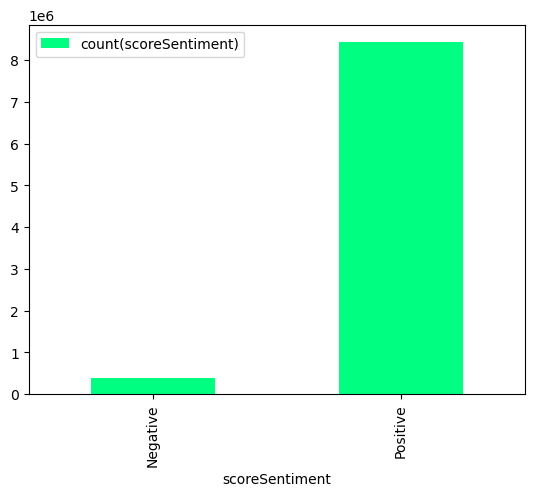

In [97]:
if runEDA:
    # convert to pandas DF
    sentDF_pandas=sentDF.toPandas()
    sentDF_pandas['scoreSentiment'] = sentDF_pandas['scoreSentiment'].astype(str) 
    sentDF_pandas['scoreSentiment']=sentDF_pandas['scoreSentiment'].replace(['0'],'Negative')
    sentDF_pandas['scoreSentiment']=sentDF_pandas['scoreSentiment'].replace(['1'],'Positive')
    sentDF_pandas.plot(kind='bar', x='scoreSentiment', y='count(scoreSentiment)', colormap='winter_r')
    
    plt.show()
    
    #sentDF.registerTempTable("sentiment_table")
    #display(SQLContext(sc).sql("select * from sentiment_table"))
    #sentDF.select('scoreSentiment').display()

In [107]:
if runEDA:
    # Generate historgram of body word count
    # There are a small (relative) number of long comments but most are under 100 words
    maxWords=100
    bwcDF=df.filter(col('bodyWordCount')<=maxWords).select('bodyWordCount')
    bwcDF_pandas=bwcDF.toPandas()
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    numBins = 50
    ax.hist(bwcDF_pandas,numBins,color='green',alpha=0.8)
    plt.show()


## Model: Predict Sentiment from body

### Set up pipeline

In [30]:
# Create TF (Term Frequency) feature
tok = Tokenizer(inputCol="body", outputCol="words")
htf = HashingTF(inputCol="words", outputCol="tf")  # numFeatures will be a hyper-parameter  

#testing
tmpDF=tok.transform(df)
tmpDF=htf.transform(tmpDF)
tmpDF.select('words','tf').show(2)

+--------------------+--------------------+
|               words|                  tf|
+--------------------+--------------------+
|              [くそ]|(262144,[85691],[...|
|[gg, this, one's,...|(262144,[5674,905...|
+--------------------+--------------------+
only showing top 2 rows



In [31]:
# Create w2v (word to vec) feature

# the comment string needs to be turned into a vector for w2v to work
# unfortunately, VectorAssember does not work on string so we need a UDF

# Create UDF (note: split(anything,0) simply means don't split)
str_to_vec=spark.udf.register("str_to_vec",
                             lambda row:row.split("#",0),
                             ArrayType(StringType()))

# set up the tranformation
rva=SQLTransformer(statement="SELECT *, str_to_vec(body) bodyVec FROM __THIS__")

w2v = Word2Vec(inputCol='bodyVec', outputCol='w2v')  # not setting minCount 

# testing
"""
tmpDF=rva.transform(df)
model=w2v.fit(tmpDF)
tmpDF=model.transform(tmpDF)
tmpDF.show(2)
"""

'\ntmpDF=rva.transform(df)\nmodel=w2v.fit(tmpDF)\ntmpDF=model.transform(tmpDF)\ntmpDF.show(2)\n'

In [32]:
# Assemble predictors
va=VectorAssembler(inputCols=['tf','w2v','bwFlag','bodyWordCount'],outputCol='features')

In [33]:
# Set up the regression model; regParam & elasticNetParam will be hyper-parameters
# CrossVal currently requires the labelCol to be precisely called 'label'
#lr = LogisticRegression(labelCol='scoreSentiment',maxIter=10)
lr = LogisticRegression(labelCol='label',maxIter=10)


In [34]:
# Build the pipeline
#pipeline=Pipeline(stages=[bkt,tok,htf,rva,w2v,va,lr])  # took out bkt since this is pre-EDA
pipeline=Pipeline(stages=[tok,htf,rva,w2v,va,lr])

### Set up hyperparameter tuning & Cross-Validation

In [35]:
# Set up the parameter grid

"""
# This version works and homes in on elasticNetParam=0
paramGrid = ParamGridBuilder() \
    .addGrid(htf.numFeatures, [200]) \
    .addGrid(lr.regParam, [0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()
"""

paramGrid = ParamGridBuilder() \
    .addGrid(htf.numFeatures, [200]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# This paramGrid for testing
"""
paramGrid = ParamGridBuilder() \
    .addGrid(htf.numFeatures, [200]) \
    .addGrid(lr.regParam, [0.3]) \
    .addGrid(lr.elasticNetParam, [0.5]) \
    .build()
"""

'\nparamGrid = ParamGridBuilder()     .addGrid(htf.numFeatures, [200])     .addGrid(lr.regParam, [0.3])     .addGrid(lr.elasticNetParam, [0.5])     .build()\n'

In [36]:
# Too inspect paramGrid, uncomment next 4 lines
"""
print('-'*30)
#print('paramGrid', paramGrid, '\n')
#print('len(paramGrid): {}'.format(len(paramGrid)))
print('-'*30)
"""

"\nprint('-'*30)\n#print('paramGrid', paramGrid, '\n')\n#print('len(paramGrid): {}'.format(len(paramGrid)))\nprint('-'*30)\n"

In [37]:
# Treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
# Using the pipeline as the estimator slows things down but is necessary if tuning featurziers.  If not, set the 
# model specification as the estimator with estimator=lr (I think; though not sure if that means lr needs to be removed from pipeline)
numFolds=5
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='label'),
                          numFolds=numFolds,
                          collectSubModels=True)

### Train the benchmark model (only based on badwords & word count)

In [ ]:
# Set up featuresRF
vaRF=VectorAssembler(inputCols=['bwFlag','bodyWordCount'],outputCol='featuresRF')

# Define the RF classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="featuresRF", numTrees=10)

# Create the pipeline
rfPipeline = Pipeline(stages=[vaRF,rf])

# Fit the model using the training data
rfModel = rfPipeline.fit(trainDF)

# save the rf model with a timestamp
timestr = time.strftime("%Y%m%d-%H%M%S")
rfModel.save("rfModel"+timestr)

print("RF model fitting complete")

In [43]:
# Generate predictions
predictionRF = rfModel.transform(testDF)
print ("RF prediction complete")

RF prediction complete


In [45]:
rfEvaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
rfAccuracy = rfEvaluator.evaluate(predictionRF)

In [47]:
print("Test Accuracy for RF:", rfAccuracy)

Test Accuracy: 0.9552675049687026


### Train the Advanced Model

In [39]:
# Determine parallelism 
# This resource: see https://databricks.com/session/model-parallelism-in-spark-ml-cross-validation
# says that best practice is parallelism = (# cores)/(# partitions) but generally not more than 10
numPartitions=trainDF.rdd.getNumPartitions()
numCores=sc.defaultParallelism
parallelism=int(round(numCores/numPartitions,0))
# also see https://stackoverflow.com/questions/42171499/get-current-number-of-partitions-of-a-dataframe

# constrain to between 1 and 10
if parallelism<1:
    parallelism=1
elif parallelism > 10:
    parallelism=10

# -----------------------------------------------------------------------------
    
"""
# Another thing we can do is treat cores as fixed and repartition to get a target parallelism
# while avoiding memory issues that occur when != cores/partitions
# in the future: verify cores/partitions is correct; might want to do something to avoid having
# too few partitions
parallelism=2
targetNumPartitions=int(round(numCores/parallelism,0))
if (targetNumPartitions>=1):
    if (targetNumPartitions<numPartitions):
        trainDF = trainDF.coalesce(targetNumPartitions) # no shuffling but can only be used for decreasing numPartitions
    else: 
        trainDF = trainDF.repartition(targetNumPartitions)  # this involves shuffling to less efficient
""" 

# -----------------------------------------------------------------------------


# However, elsewhere, you typically see that partitions should be 2x to 4x the number of cores!
# So, we could just override (note: 4 yielded memory errors)
if overrideParallelism:
    parallelism=overrideParallelism


In [40]:
# print out parallelism
parallelism

1

In [41]:
# Cache trainDF to speed up cross validation; we could use .select(colnames...) to use less memory
# Cache & persist failed with 96GB and down to 50/50 train test split
# yeah! worked with 25/25/50 train/test/holdout split with 96GB allocated!!!
if persistTrainDF:
    #trainDF=trainDF.cache()
    trainDF=trainDF.persist(StorageLevel.MEMORY_AND_DISK)
    trainDF.count()  # call count to actually cache the data


In [42]:
if len(loadCVmodel)==0:
    # Run cross-validation, and choose the best set of parameters. Print the training time.
    import time
    t0 = time.time()
    if parallelism<=1:
        cvModel = crossval.fit(trainDF) # train models (no parallelism)
    else:    
        cvModel = crossval.setParallelism(parallelism).fit(trainDF) # train models in parallel
    print("train time:", time.time() - t0)
    print('-'*30)
    # Took 3580 secs (~1hr) to run single params set with 50/50 split, 5 fold on 8 cores with 32 GB memmory & no parallelism & no cache/persist
    # 10/10/90 train/test/holdout without parallelism took 3352 secs for 6 model variations (10 mins per model)
    
    # save the model with a timestamp
    timestr = time.strftime("%Y%m%d-%H%M%S")
    cvModel.save("lrModel"+timestr)
    pipeline.save("lrPipeline"+timestr)
else: 
    # Load the model and the pipeline  (should these be preceded by "val")
    cvModel = CrossValidatorModel.load(loadCVmodel)
    #val sameModel = PipelineModel.load("/path-to-my-pipeline/spark-log-reg-transfer-pipeline")

train time: 3352.6148397922516
------------------------------


In [43]:
# release the cache
if persistTrainDF:
    trainDF.unpersist()

In [44]:
cvModel.bestModel.stages[-1].extractParamMap()
# best model has the following:
# elasticNetParam = 0
# regParam = 0.01

{Param(parent='LogisticRegression_4446ecd1f38f', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LogisticRegression_4446ecd1f38f', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0,
 Param(parent='LogisticRegression_4446ecd1f38f', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto',
 Param(parent='LogisticRegression_4446ecd1f38f', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LogisticRegression_4446ecd1f38f', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LogisticRegression_4446ecd1f38f', name='labelCol', doc='label column name.'): 'label',
 Param(parent='LogisticRegression_4446ecd1f38f', name='maxIter', doc='max number of iterations (>= 0).'):

## Model Evaluation

In [46]:
# Create the necessary evaluators
evaluator=BinaryClassificationEvaluator(labelCol='label')
mcEvaluator = MulticlassClassificationEvaluator(metricName="accuracy")

In [47]:
# Generate predictions
predict_train=cvModel.transform(trainDF)
predict_test=cvModel.transform(testDF)

In [48]:
#predict_test.show(3)
# besides initial df cols and those created by pipeline, we ahve label, rawPrediction, probability, and prediction

### Accuracy

In [49]:
print("Train Accuracy:", mcEvaluator.evaluate(predict_train))
print("Test Accuracy:", mcEvaluator.evaluate(predict_test))

Train Accuracy: 0.9549860734338707
Test Accuracy: 0.9552607024095798


### precision, recall, F1 score
Source: https://stackoverflow.com/questions/60772315/how-to-evaluate-a-classifier-with-pyspark-2-4-5

In [50]:
weightedPrecision = mcEvaluator.evaluate(predict_test, {mcEvaluator.metricName: "weightedPrecision"})
print("Test precision is {}".format(weightedPrecision))

weightedRecall = mcEvaluator.evaluate(predict_test, {mcEvaluator.metricName: "weightedRecall"})
print("Test recall is {}".format(weightedRecall))

f1 = mcEvaluator.evaluate(predict_test, {mcEvaluator.metricName: "f1"})
print("Test f1 is {}".format(f1))

Test precision is 0.9214841866897692
Test recall is 0.9552607024095798
Test f1 is 0.9334140348304236


In [51]:
weightedPrecision = mcEvaluator.evaluate(predict_train, {mcEvaluator.metricName: "weightedPrecision"})
print("Train precision is {}".format(weightedPrecision))

weightedRecall = mcEvaluator.evaluate(predict_train, {mcEvaluator.metricName: "weightedRecall"})
print("Train recall is {}".format(weightedRecall))

f1 = mcEvaluator.evaluate(predict_train, {mcEvaluator.metricName: "f1"})
print("Train f1 is {}".format(f1))

Train precision is 0.9232611846478553
Train recall is 0.9549860734338705
Train f1 is 0.9330062499313787


### Confusion Matrix
Source: https://stackoverflow.com/questions/58404845/confusion-matrix-to-get-precsion-recall-f1score

Confusion matrix references that may be helpful if the above does not work: 

https://gist.github.com/ispmarin/05feacd8be5e2901cf2b35453a148060

https://shihaojran.com/distributed-machine-learning-using-pyspark/

In [52]:
#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = predict_test.select(['prediction','label']).withColumn('label', col('label').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print("Confustion matrix for test:")
print(metrics.confusionMatrix().toArray())

Confustion matrix for test:
[[2.00000e+00 3.94530e+04]
 [8.00000e+00 8.42558e+05]]


In [53]:
#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = predict_train.select(['prediction','label']).withColumn('label', col('label').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print("Confustion matrix for train:")
print(metrics.confusionMatrix().toArray())

Confustion matrix for train:
[[2.00000e+00 3.97020e+04]
 [6.00000e+00 8.42417e+05]]


### AUC

In [54]:
evalTrain=evaluator.evaluate(predict_train)
evalTest=evaluator.evaluate(predict_test)

In [55]:

print("The area under ROC for train set after CV  is {}".format(evalTrain))
print("The area under ROC for test set after CV  is {}".format(evalTest))

# source: https://dhiraj-p-rai.medium.com/logistic-regression-in-spark-ml-8a95b5f5434c

The area under ROC for train set after CV  is 0.6010364050742824
The area under ROC for test set after CV  is 0.5955939049250416


## Sensitivity Analysis

In [ ]:
# My attempt to access submodels so don't need to fit again for sensitivity
# There is very little documentation for this online.  subModels appears to be 
# a folds x models 2D list of pipelines. However, not sure how to extract a single model
#cvModel.subModels
#cvModel.subModels[1][1].stages[-1].extractParamMap()

In [72]:
# Our best model has elasticNetParam=0 and regParam=0.01.  So, we can do sensitivity analysis
# by comparing to regParam=0.1 (we have this in subModels but I could not out how to access)
paramGrid_sens = ParamGridBuilder() \
    .addGrid(htf.numFeatures, [200]) \
    .addGrid(lr.regParam, [0.1]) \
    .addGrid(lr.elasticNetParam, [0.0]) \
    .build()

In [73]:
# Treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
# Using the pipeline as the estimator slows things down but is necessary if tuning featurziers.  If not, set the 
# model specification as the estimator with estimator=lr (I think; though not sure if that means lr needs to be removed from pipeline)
numFolds=5
crossval_sens = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid_sens,
                          evaluator=BinaryClassificationEvaluator(labelCol='label'),
                          numFolds=numFolds,
                          collectSubModels=False)

In [74]:
if len(loadCVmodelSens)==0:
    cvModel_sens = crossval_sens.fit(trainDF) # train models (no parallelism)
    print ("Sensitivity fit complete")
else:
    cvModel_sens = CrossValidatorModel.load(loadCVmodelSens)

In [77]:
# save the sensitivity model if it was just fitted
if len(loadCVmodelSens)==0:
    # save the model with a timestamp
    timestr = time.strftime("%Y%m%d-%H%M%S")
    cvModel_sens.save("lrModelSens"+timestr)

In [79]:
# Generate predictions
predict_train_sens=cvModel_sens.transform(trainDF)
predict_test_sens=cvModel_sens.transform(testDF)
print ("Sensitivity prediction generation complete")

Sensitivity prediction generation complete


In [80]:
evaluator=BinaryClassificationEvaluator(labelCol='label')
evalTrain=evaluator.evaluate(predict_train_sens)
evalTest=evaluator.evaluate(predict_test_sens)
print ("Sensitivity evaluate complete")

Sensitivity evaluate complete


In [81]:

print("The area under ROC for train set after CV  is {}".format(evalTrain))
print("The area under ROC for test set after CV  is {}".format(evalTest))

# source: https://dhiraj-p-rai.medium.com/logistic-regression-in-spark-ml-8a95b5f5434c

The area under ROC for train set after CV  is 0.5997333917195864
The area under ROC for test set after CV  is 0.5950056297766232


## Save notebook as PDF document

In [91]:
# Save notebook as PDF document
!jupyter nbconvert --to pdf `pwd`/*.ipynb

[NbConvertApp] Converting notebook /sfs/qumulo/qhome/jdd5dw/ds5110-project/Jeremey_code.ipynb to pdf
[NbConvertApp] Writing 123567 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 112633 bytes to /sfs/qumulo/qhome/jdd5dw/ds5110-project/Jeremey_code.pdf
[NbConvertApp] Converting notebook /sfs/qumulo/qhome/jdd5dw/ds5110-project/Jeremey_code_BKUP202107300829.ipynb to pdf
[NbConvertApp] Writing 128667 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successf